# Towards Automated GDPR-compliance in Organizations: A Natural Language Processing Based Machine Learning Approach

# 1. Classification and Calibration

This script includes a supervised machine learning-based NLP pipeline to build five classifiers that can assess whether privacy policies disclose the five GDPR privacy policy core requirements. It was hypothesized that integrating NLP in our approach was essential since privacy policies are expressed in natural language. The dataset for training the models was acquired from [1] containing 250 anonymized privacy policies comprising over 18,300 natural sentences labeled according to the five GDPR privacy policy core requirements in the Table 1. Our approach resulted in five different classification models—trained using Python's Scikit-Learn library—each focusing on one of the GDPR privacy policy core requirements.


|No.|	Requirement|Required content in privacy policy|
|:---:|:---|:---|
|1| DPO | Contact details for the data protection officer or equivalent |
|2| Purpose | Disclosure of the purpose for which personal data is or is not used for |
|3| Acquired data | Disclosure that personal data is or is not collected, and/or which data is collected |
|4| Data sharing | Disclosure if 3rd parties can or cannot access a user’s personal data |
|5| Rights | Disclosure of the user’s right to rectify or erase personal data |

<center>Table 1: Five GDPR Privacy Policy Core Requirements</center>

#### Data set
This manually labeled data set [1] comprises 250 individual policies, containing over 18,300 natural sentences. The data is labeled according to the GDPR privacy policy key requirements as presented in Table 1. The data can be accessed via this link: https://git.aisec.fraunhofer.de/projects/GDPRCOM/repos/on-gdpr-compliance/browse.

---
#### References
[1] Müller, Nicolas M., et al. "On GDPR compliance of companies’ privacy policies." International Conference on Text, Speech, and Dialogue. Springer, Cham, 2019.

#### Libraries

In [1]:
from platform import python_version
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from nltk.stem import PorterStemmer
# from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from imblearn.over_sampling import RandomOverSampler
from time import time
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, f1_score, accuracy_score, recall_score, average_precision_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import pickle
from shapely.geometry import LineString
import array as arr
import matplotlib.pyplot as plt  
from scipy.stats import binom
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from imblearn.pipeline import Pipeline as ILPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
print(python_version())

3.8.5


---

## Import data: 18.397 labeled sentence snippets

In [3]:
DATA_FILE = "data/GDPR.csv"

In [5]:
dataset = pandas.read_csv(DATA_FILE, sep='\t', encoding='utf-8')
print(dataset.shape)

(18397, 6)


### Explore balance of dataset

Text(0.5, 0, 'GDPR Assessment Criteria')

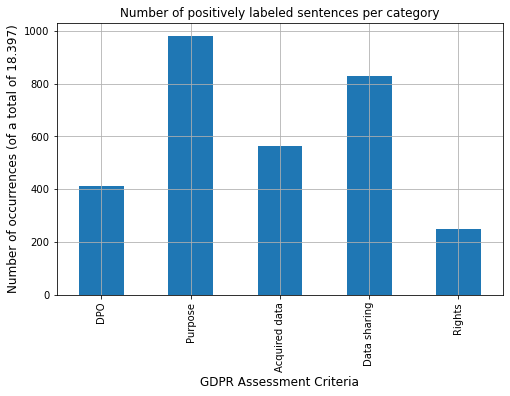

In [7]:
categories = list(dataset.columns)[1:] # select all except 'text' column

counts = []
for column in categories:
    counts.append((column, dataset[column].value_counts()[1]))

df_stats = pandas.DataFrame(counts, columns=['GDPR_criteria', 'number_of_pos_sen'])

df_stats.plot(x='GDPR_criteria', y='number_of_pos_sen', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of positively labeled sentences per category")
plt.ylabel('Number of occurrences (of a total of 18.397)', fontsize=12)
plt.xlabel('GDPR Assessment Criteria', fontsize=12)

### Explore number of multi-labeled sentences
Source: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

C:\Users\aaberkan\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Number GDPR criteria per sentence')

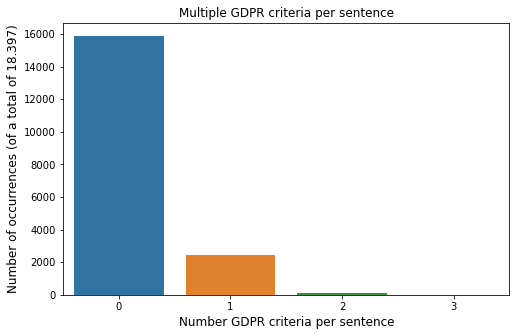

In [8]:
rowsums = dataset.iloc[:,2:].sum(axis=1)
x = rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple GDPR criteria per sentence")
plt.ylabel('Number of occurrences (of a total of 18.397)', fontsize=12)
plt.xlabel('Number GDPR criteria per sentence', fontsize=12)

###### Note: the vast majority of the sentences is not labeled at all (almost 16.000)
The problem of class imbalance shall be addressed below.

---

## Preprocessing

The preprocessing consists of the following steps: 
- addressing the class imbalance by oversampling the minority class in the training set;
- removing punctuation;
- removing words containing digits (authors of data set used these words to scramble the data, e.g., company_32782);
- removing stopwords;
- stemming;

Lastly, we also conduct a stratified split on the data set to address the class imbalance, and introduce a method to oversample the minority class in the training set later on. 

In [9]:
# This method executes the previously mentioned preprocessing tasks.
# It takes a list of sentences as an argument and returns a list of preprocessed sentences.
def preprocessing(pps):
#     tokenizer = nlp.tokenizer
    # tokenize sentences
    tokenized_sent = [sent.split() for sent in pps]
    
    # remove punctuation
    tokenized_sent = [[re.sub('[,’\'\.!?&“”():*_;"]', '', y) for y in x] for x in tokenized_sent]
    
    # remove words with digits
    tokenized_sent = [[y for y in x if not any(c.isdigit() for c in y)] for x in tokenized_sent]
    
    # remove stopwords   
    tokenized_sent_clean = tokenized_sent
#     tokenized_sent_clean = [[y for y in x if y not in stopwords.words('english')] for x in tokenized_sent]
    
    # from nltk.stem import PorterStemmer
    porter = PorterStemmer()
    tokenized_sent_clean = [[porter.stem(y) for y in x] for x in tokenized_sent_clean]
    
#     lemmatizer = WordNetLemmatizer()
#     tokenized_sent_clean = [[lemmatizer.lemmatize(y) for y in x] for x in tokenized_sent_clean]

    detokenized_pps = []
    for i in range(len(tokenized_sent_clean)):
        t = ' '.join(tokenized_sent_clean[i])
        detokenized_pps.append(t) 
    
    return detokenized_pps

### Gridsearch

In [10]:
def make_and_train_pipeline(
    X, y,
    transformer = True,
    sampler = True,
    classifier = True,
):

    if transformer is True: transformer = TfidfTransformer
    if sampler is True: sampler = RandomOverSampler
    if classifier is True: classifier = LogisticRegression
    
#     steps = [("vec", CountVectorizer())]
    steps = [("tfidf", TfidfVectorizer())]
#     steps = []
#     if transformer: steps += [("tra", transformer())]
    if sampler: steps += [("sam", sampler(random_state = 42))]
    if classifier is ClassifierChain:
        steps += [("cla", classifier(LogisticRegression()))]
    elif classifier: steps += [("cla", classifier())]
    
    pipeline = ILPipeline(steps)

    parameters = {
#         "vec__stop_words": ("english",),
#         "vec__max_df": (0.1, 0.4, 0.5, 0.6, 1.0),
#         'vec__max_features': (500, 1000, 2000, 5000),
#         "vec__ngram_range": ((1, 1), (1, 2), (1, 3)),
#         "tfidf__max_df": (0.1, 0.4, 0.5, 0.6, 1.0),
        "tfidf__max_features": (500, 1000, 2000, 5000),
        "tfidf__ngram_range": ((1, 1), (1, 2), (1, 3)),
#         "tra__use_idf": (True,),
#         "tra__norm": ("l2",)
    }
    if classifier is LogisticRegression:
        parameters.update({
            "cla__C": (0.1, 0.01, 0.001, 0.0001),
#             "cla__penalty": ("l2",),
#             "cla__solver": ("lbfgs",),
            'cla__max_iter': (200,)
        })
    if classifier is RandomForestClassifier:
        parameters.update({
            "cla__max_features": ("sqrt",),
            "cla__n_estimators": (500,),
        })

    grid_search = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1, verbose=4, scoring="roc_auc")
    grid_search.fit(X, y)

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    return grid_search

In [11]:
def plot_results(y, preds):
    print(f" \
        {roc_auc_score(y, preds >= .5) = }\n \
        {accuracy_score(y, preds >= .5) = }\n \
        {recall_score(y, preds >= .5) = }\n \
        {precision_score(y, preds >= .5) = }"
    )
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(np.arange(0, .8, 0.01), [roc_auc_score(y, preds >= t) for t in np.arange(0, .8, 0.01)])
    ax1.plot(np.arange(0, .8, 0.01), [recall_score(y, preds >= t) for t in np.arange(0, .8, 0.01)])
    ax1.plot(np.arange(0, .8, 0.01), [precision_score(y, preds >= t) for t in np.arange(0, .8, 0.01)])
    ax1.plot(np.arange(0, .8, 0.01), [accuracy_score(y, preds >= t) for t in np.arange(0, .8, 0.01)])
    ax1.legend(labels=["ROC", "recall", "precision", "accuracy"])
    RocCurveDisplay.from_predictions(y, preds, ax=ax2)
    plt.show()

In [14]:
for i, category in enumerate(categories):
    print(category)
    train, test = train_test_split(dataset, stratify=dataset[category], test_size=0.2, random_state=42)
    y_train, y_test = train[category], test[category]
    lr_model = make_and_train_pipeline(train.Text, y_train)
#     plot_results(y_test, lr_model.predict_proba(test.Text)[:, 1])
    
    print("Same category with preprocessing: ")
    prep_train_text, prep_test_text = preprocessing(train.Text), preprocessing(test.Text)
    lr_model = make_and_train_pipeline(prep_train_text, y_train)
#     plot_results(y_test, lr_model.predict_proba(prep_test_text)[:, 1])
    print()
    print("--- --- --- --- --- --- --- --- --- ---")

DPO
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.983
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 2)
Same category with preprocessing: 
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.981
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 2)

--- --- --- --- --- --- --- --- --- ---
Purpose
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.932
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 2)
Same category with preprocessing: 
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.932
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 2)

--- --- --- --- --- --- --- --- --- ---
Acquired data
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best

# Predict & Evaluate

We use the optimized parameters to build classification models. These confusion matrix of the test set (using these classification models) is then computed based on the ideal threshold/cutoff value, that corresponds with the highest F1-score.

In [15]:
def cutoff_results_f1(y_test, y_prob):
    # Let's create columns with different probability cutoffs 
    thresholds = [float(x)/50 for x in range(50)]
    f1_list = []
    
    for i in thresholds:
        y_pred_o = np.where(y_prob > i, 1, 0)
        f1_list.append(f1_score(y_test, y_pred_o))

    max_f1 = max(f1_list)
    print(f"Max F1-score: {max_f1}")
    max_index = f1_list.index(max_f1)
    y_pred_max = np.where(y_prob > thresholds[max_index], 1, 0)

    return f1_list, thresholds, y_pred_max

In [16]:
def plot_f1_threshold(y_test, y_prob):
    f1_list, thresholds, y_pred_max = cutoff_results_f1(y_test, y_prob)
    plt.plot(thresholds, f1_list, label = "f1-score")
    plt.legend()
    plt.xlabel('Treshold')
    plt.ylabel('F1-score')
    plt.title('F1-score Performance: '+ category)
    plt.show()
    return y_pred_max

In [17]:
# Oversamples the minority class using the RandomOverSampler class
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
def oversample_data(x, y):    
#     oversample = RandomOverSampler(sampling_strategy='minority', random_state = 42)
    oversample = RandomOverSampler(random_state = 42)
    x_over, y_over = oversample.fit_resample(x, y)
    return x_over, y_over

In [18]:
def print_important_features(vectorizer, lr):
    print("Most important features:")
    words = vectorizer.get_feature_names_out()
    for label, coefs, intercept in zip(lr.classes_, lr.coef_, lr.intercept_):
        print(label)
        sort_zipped_list = sorted(zip(words, coefs), key = lambda x: x[1], reverse = True) 
        for t, c in list(sort_zipped_list)[:10]:
            print(t, c)
        print("...")
        print("INTERCEPT:" +str(intercept))
        print("...")
        for t, c in list(sort_zipped_list)[-10:]:
            print(t, c)
        print()

Using optimized parameters

In [19]:
ngrams = [(1,2), (1,2), (1,3), (1,2), (1,1)]
max_iter = 200
C = 0.1
max_features_r = [5000, 5000, 5000, 5000, 2000]
preprocessing_r = [False, True, True, True, True]

DPO
Most important features:
0
domain 5.369939434117046
contact 3.982949564552181
please 3.6975035200579995
at 3.350827938132549
ico 3.086463944940196
officer 2.949216955218701
telephone 2.8901499954015173
us at 2.830115634684919
data controller 2.803806747011564
data protection 2.6869806511873255
...
INTERCEPT:-2.3175102354556487
...
it -0.8511888680238887
we may -0.8672315096156576
other -0.9722385496360257
services -0.9803828354602597
that -1.0839272739916515
cookies -1.1196887763995635
not -1.1572629980651572
will -1.2100011309997392
we -1.5261093865330764
and -2.1714565667858934

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3597
           1       0.39      0.96      0.56        83

    accuracy                           0.97      3680
   macro avg       0.69      0.96      0.77      3680
weighted avg       0.99      0.97      0.97      3680

ROC AUC: 0.9645521200732874
Confusion matrix DPO:
[[3472  125]
 [   3   80]]
Conf

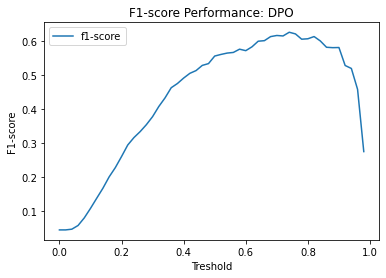

[[3535   62]
 [  17   66]]
--- --- --- --- --- --- 
--- --- --- --- --- --- 

Purpose
Most important features:
0
use 3.5245444910662225
purpos 3.444640077661025
to 3.3589014297338733
use your 3.0008184964467293
and 2.4572771227149532
for 2.36035964405033
you 2.215695800910636
servic 2.1884075525883904
administ 2.170219674289761
our 2.0188872324121285
...
INTERCEPT:-2.0096003499885198
...
if -0.9948762930572872
transfer -1.0016258387179302
pleas -1.0746261917040365
access -1.1365532039406552
to the -1.170726707869147
right to -1.17809188178301
how -1.2162365006504559
privaci -1.3374242912720942
right -1.44500199824423
cooki -2.1797556536705236

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      3484
           1       0.31      0.80      0.44       196

    accuracy                           0.89      3680
   macro avg       0.65      0.85      0.69      3680
weighted avg       0.95      0.89      0.91      3680

ROC AUC: 0.8477295625

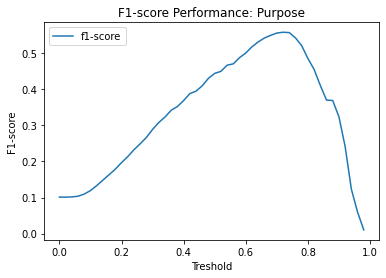

[[3391   93]
 [  84  112]]
--- --- --- --- --- --- 
--- --- --- --- --- --- 

Acquired data
Most important features:
0
collect 4.311927152506639
name 4.191462588921572
address 3.553154018993477
record 3.179207715512663
detail 3.1217012033190943
health 2.682993134291297
includ 2.6462855481906855
photograph 2.525772945613433
ident 2.350790692022595
person 2.3427267265492264
...
INTERCEPT:-1.9549112097946155
...
to -0.9370096187432714
secur -1.0084994266051917
share -1.0353475761780089
privaci -1.0944124623485942
cooki -1.1487606663925312
your person inform -1.1883578419035006
it -1.1921517935124073
right -1.313357685233753
your person -1.3185116631046057
how -1.3369896667129053

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3567
           1       0.33      0.76      0.46       113

    accuracy                           0.94      3680
   macro avg       0.66      0.86      0.71      3680
weighted avg       0.97      0.94      0.9

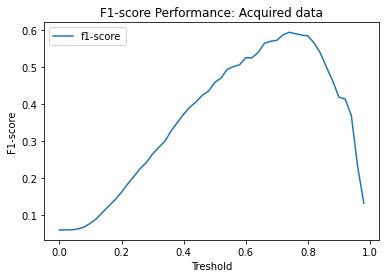

[[3524   43]
 [  47   66]]
--- --- --- --- --- --- 
--- --- --- --- --- --- 

Data sharing
Most important features:
0
share 6.010586075574314
disclos 4.660573728426451
parti 3.7208630381373076
third parti 3.3630788410888943
third 3.350040588385946
transfer 3.2611185710854715
share your 3.2582780913326936
inform with 3.053283636191983
with 2.8365468710490145
pass 2.480571172464701
...
INTERCEPT:-2.5844143608752894
...
site -0.8859703623905149
account -0.9025640592053933
use your -0.9345559180383483
collect -0.9778931874716233
right -0.9797221148099938
from -1.0111502208128924
websit -1.266327896427972
cooki -1.325231260848767
use -1.8343947497658
you -2.04761109864752

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3514
           1       0.46      0.89      0.61       166

    accuracy                           0.95      3680
   macro avg       0.73      0.92      0.79      3680
weighted avg       0.97      0.95      0.96      36

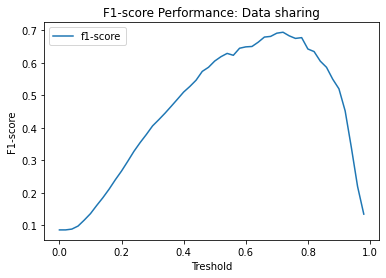

[[3456   58]
 [  47  119]]
--- --- --- --- --- --- 
--- --- --- --- --- --- 

Rights
Most important features:
0
delet 6.1958172600790435
correct 5.75577036548901
remov 4.990188969203597
erasur 4.93547376248821
right 4.463459645728434
eras 4.431787364536628
rectif 3.710602186800128
request 3.6466320017678404
forgotten 3.438451496617487
rectifi 3.246393127938354
...
INTERCEPT:-3.3549459555326737
...
third -0.8730666151850905
parti -0.9177284200006315
polici -0.9928610727534555
cooki -1.0832673026169315
use -1.105388615894681
collect -1.1142382998900562
privaci -1.1367732178590757
websit -1.2185942596543173
servic -1.3305235362750008
are -1.3510470822033933

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3630
           1       0.38      0.92      0.54        50

    accuracy                           0.98      3680
   macro avg       0.69      0.95      0.76      3680
weighted avg       0.99      0.98      0.98      3680

ROC AUC: 

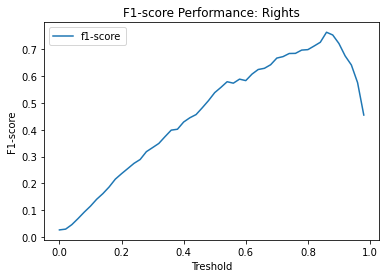

[[3620   10]
 [  13   37]]
--- --- --- --- --- --- 
--- --- --- --- --- --- 



In [20]:
for i, category in enumerate(categories):
    print(category)
    train, test = train_test_split(dataset, stratify=dataset[category], random_state=42, test_size = 0.2)
    x_train, x_test = train.Text, test.Text
    y_train, y_test = train[category], test[category]
    
    vectorizer = TfidfVectorizer(
        ngram_range = ngrams[i],
        max_features = max_features_r[i])
    
    if preprocessing_r[i]:
        x_train = preprocessing(x_train)
        x_test = preprocessing(x_test)

    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)

    x_train, y_train = oversample_data(x_train, y_train)
    
    lr = LogisticRegression(max_iter = max_iter, C = C)
    lr.fit(x_train, y_train)
    
    print_important_features(vectorizer, lr)
    
    y_pred = lr.predict(x_test)
    y_prob = lr.predict_proba(x_test)[:,1]
    
    print(classification_report(y_test, y_pred))
    print("ROC AUC: " + str(roc_auc_score(y_test, y_pred)))
    
    print("Confusion matrix " + category + ":")
    print(confusion_matrix(y_test, y_pred))

    
    print("Confusion matrix after thresholding " + category + ":")
    y_cutoff = plot_f1_threshold(y_test, y_prob)
    print(confusion_matrix(y_test, y_cutoff))
    print("--- --- --- --- --- --- ")
    print("--- --- --- --- --- --- ")
    print()

---

# Retrain on whole data set

In [21]:
ngrams = [(1,2), (1,2), (1,3), (1,2), (1,1)]
max_iter = 200
C = 0.1
max_features_r = [5000, 5000, 5000, 5000, 2000]
preprocessing_r = [False, True, True, True, True]

In [22]:
for i, category in enumerate(categories):
    X, y = dataset.Text, dataset[category]
    
    vectorizer = TfidfVectorizer(
        ngram_range = ngrams[i],
        max_features = max_features_r[i])
    
    if preprocessing_r[i]: X = preprocessing(X);

    X = vectorizer.fit_transform(X)

    X, y = oversample_data(X, y)
    
    lr = LogisticRegression(max_iter = max_iter, C = C)
    lr.fit(X, y)
    
    # Save to file in the current working directory
    lr_file = "linreg-oversampling-" + category + ".pkl"
    with open(lr_file, 'wb') as file:
        pickle.dump((vectorizer, lr), file)

---

# Increase Certainty of Predictions
The classification results lead to the following question: __When does a privacy policy as a whole meet the GDPR privacy policy core requirement at issue?__ Is the mere presence of one positively classified sentence enough to consider the whole privacy policy compliant with the GDPR class in question? In this research, we decided to raise the certainty of our predictions by addressing the following question: __What number of positive sentences are needed to classify, with a desired level of confidence, a new privacy policy as compliant with the requirement at issue?__ To address this question, we exert the inverse cumulative distribution function of the binomial distribution to set a threshold of the minimum positive sentences required to meet a given confidence level. This step is necessary since our classification models work at the sentence-level rather than at the document-level due to the data set used to train the models. This data set consists of labeled sentences extracted from privacy policies without insight into the structure of the original documents (i.e., privacy policies).

Given a contingency table consisting of true positive (TP), false positive (FP), true negative (TN), and false negative (FN) values, based on a data set comprising, in total, E = TP + FP + TN + FN elements—$\hat{P}$ describes the elements predicted as positive, i.e., $\hat{P}$ = TP + FP. The probability that a positively predicted element is a true positive can then be described as $P(y=1|\hat{y}=1) = \frac{TP}{\hat{P}}$. Using a binomial distribution, the probability that exactly $k$ elements from $\hat{P}$ are true positives can be calculated as follows:

\begin{equation}
      P(|TP| = k) = \binom{\hat{P}}{k} P(y=1|\hat{y}=1)^k (1 - P(y=1|\hat{y}=1))^{\hat{P}-k} 
      = \binom{\hat{P}}{k} P_{TP}^k P_{FP}^{\hat{P}-k}
\end{equation}

It follows that the cumulative distribution function is equal to:

\begin{equation}
      P(|TP| \leq k) = \sum_{i=0}^k \binom{\hat{P}}{i} P_{TP}^k P_{FP}^{\hat{P}-i}
\end{equation}

We focus on the probability that the number of TP exceeds a given value, therefore we consider the inverse cumulative distribution:

\begin{equation}
      P(|TP| > k) = 1 - P(|TP| \leq k) = 1 - \sum_{i=0}^k \binom{\hat{P}}{i} P_{TP}^k P_{FP}^{\hat{P}-i}
\end{equation}

We now find the highest value of $k$ (i.e., $k'$) that keeps the inverse cumulative distribution above a given desired probability $Z$:

\begin{equation}
    k' = argmax_{k\in[0,|TP|]} P(|TP| > k) \geq Z
\end{equation} 

Given a new set of elements (e.g., sentences in a privacy policy) with $E_n$ elements of which $\hat{P}_n$ are predicted as positive by the model. We consider the document to be positive if the threshold, ${Q}=\frac{k'}{E}$ is met, i.e., $\frac{\hat{P}}{E_n} \geq Q$.

### Example: label = DPO

|DPO (3548N, 132P)| Predicted N | Predicted P |
|:---:|:---:|:---:|
| Actual N | TN = 3535 | FP = 62 |
| Actual P | FN = 17 | TP = 66 |

* ${E}$ = TP + FP + TN + FN = 66 + 62 + 3535 + 17 = 3680 <br>
* $\hat{P}$ = TP + FP = 66 + 62 = 128 <br>
* $P(y=1|\hat{y}=1) = \frac{TP}{\hat{P}} = \frac{66}{128}$.

#### Binomial Distribution
Using a binomial distribution, the probability that exactly $k$ elements from $\hat{P}$ are true positives can be calculated as follows:

\begin{equation}
      P(|TP| = k) = \binom{\hat{P}}{k} P(y=1|\hat{y}=1)^k (1 - P(y=1|\hat{y}=1))^{\hat{P}-k} 
      = \binom{\hat{P}}{k} P_{TP}^k P_{FP}^{\hat{P}-k}
\end{equation}

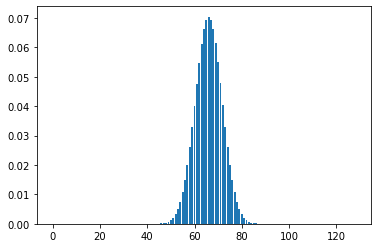

In [23]:
# setting the values of n and p
n = 128
k = 128
p = (66/128)

# defining list of r values
r_values = list(range(k + 1))

# list of pmf values
dist = [binom.pmf(r, n, p) for r in r_values ]

# plotting the graph 
plt.bar(r_values, dist)
plt.show()

#### Cumulative Binomial Distribution
It follows that the cumulative distribution function is equal to:

\begin{equation}
      P(|TP| \leq k) = \sum_{i=0}^k \binom{\hat{P}}{i} P_{TP}^k P_{FP}^{\hat{P}-i}
\end{equation}

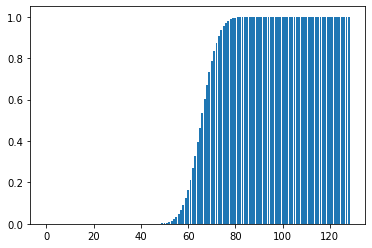

In [24]:
n = 128
k = 128
p = (66/128)

# defining list of r values
r_values = list(range(k + 1))

# list of pmf values
dist = [binom.cdf(r, n, p) for r in r_values ]

# plotting the graph 
plt.bar(r_values, dist)
plt.show()

#### Cumulative Binomial Distribution: step 1

We focus on the probability that the number of TP exceeds a given value, therefore we consider the inverse cumulative distribution:

\begin{equation}
      P(|TP| > k) = 1 - P(|TP| \leq k) = 1 - \sum_{i=0}^k \binom{\hat{P}}{i} P_{TP}^k P_{FP}^{\hat{P}-i}
\end{equation}

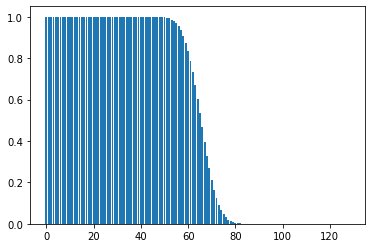

In [25]:
n = 128
k = 128
p = (66/128)

# defining list of r values
r_values = list(range(k + 1))

# list of pmf values
dist = [(1-binom.cdf(r, n, p)) for r in r_values]

# plotting the graph 
plt.bar(r_values, dist)
plt.show()

#### Cumulative Binomial Distribution: step 2

We now find the highest value of $k$ (i.e., $k'$) that keeps the inverse cumulative distribution above a given desired probability $Z$:

\begin{equation}
    k' = argmax_{k\in[0,|TP|]} P(|TP| > k) \geq Z
\end{equation} 

Given a new set of elements (e.g., sentences in a privacy policy) with $E_n$ elements of which $\hat{P}_n$ are predicted as positive by the model. We consider the document to be positive if the threshold, ${Q}=\frac{k'}{E}$ is met, i.e., $\frac{\hat{P}}{E_n} \geq Q$.

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 20: 1.0, 21: 0.9999999999999999, 22: 0.9999999999999992, 23: 0.9999999999999963, 24: 0.9999999999999827, 25: 0.9999999999999222, 26: 0.9999999999996669, 27: 0.9999999999986408, 28: 0.9999999999947005, 29: 0.9999999999802363, 30: 0.9999999999294251, 31: 0.9999999997584331, 32: 0.9999999992066738, 33: 0.9999999974979996, 34: 0.9999999924157478, 35: 0.99999997788566, 36: 0.9999999379279184, 37: 0.9999998321635738, 38: 0.9999995625452998, 39: 0.9999989002076043, 40: 0.9999973314287238, 41: 0.9999937470590393, 42: 0.9999858432761177, 43: 0.9999690158673169, 44: 0.9999344111153473, 45: 0.9998656481243368, 46: 0.9997335711030341, 47: 0.9994882722563317, 48: 0.9990476245296952, 49: 0.9982817851627956, 50: 0.9969936927566618, 51: 0.9948965707747591, 52: 0.9915908716705315, 53: 0.9865448014615219, 54: 0.9790842137869109, 55: 0.

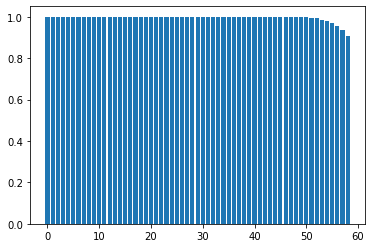

k': 58
P(|TP| > 58): 0.9076502445343784
Threshold value (k'/E): 0.01576086956521739


In [26]:
E_total_elements = 3680
Z = 0.9
n = 128
k = 125
p = (64/132)
p = (66/128)

# defining list of r values
r_values = list(range(k + 1))

# list of pmf values
dist = [(1-binom.cdf(r, n, p)) for r in r_values]
# k_list = [r for r in r_values if (dist[r] > t)]

k_list = {r:dist[r] for r in r_values if (dist[r] > Z)}

print(k_list)

plt.bar(k_list.keys(), k_list.values())
plt.show()

k_max = max(k_list, key=int)
print("k':", k_max)
print("P(|TP| > " + str(k_max) + "):", k_list[k_max])
print("Threshold value (k'/E):", (k_max/E_total_elements))

Result:
* $k' = 58$
* $P(|TP| > k') = P(|TP| > 58) = 0.90765 $

$$ Q = \frac{k'}{E} = \frac{58}{3680} = 0.01576086956521739$$

## Calibrate all thresholds

In [27]:
def calculate_threshold (E_total_elements, Z, n, k, p):
    # defining list of r values
    r_values = list(range(k + 1))
    # list of pmf values
    dist = [(1-binom.cdf(r, n, p)) for r in r_values]

    k_list = {r:dist[r] for r in r_values if (dist[r] > Z)}

#     print(k_list)
#     plt.bar(k_list.keys(), k_list.values())
#     plt.show()

    k_max = max(k_list, key=int)
    print("k':", k_max)
    print("P(|TP| > " + str(k_max) +"):", k_list[k_max])
    print("Threshold value (k'/E):", (k_max/E_total_elements))
    print()
    return (k_max/E_total_elements)

In [28]:
print("DPO")
dpo_threshold = calculate_threshold (3680, 0.9, 128, 128, (66/128))

print("Purpose")
purpose_threshold = calculate_threshold (3680, 0.9, 205, 205, (112/205))

print("Acquired Data")
acquired_data_threshold = calculate_threshold (3680, 0.9, 109, 109, (66/109))

print("Data Sharing")
data_sharing_threshold = calculate_threshold (3680, 0.9, 177, 177, (119/177))

print("Rights")
rights_threshold = calculate_threshold (3680, 0.9, 47, 47, (37/47))
print("")

DPO
k': 58
P(|TP| > 58): 0.9076502445343784
Threshold value (k'/E): 0.01576086956521739

Purpose
k': 102
P(|TP| > 102): 0.9084884943242253
Threshold value (k'/E): 0.027717391304347826

Acquired Data
k': 58
P(|TP| > 58): 0.9283144519938604
Threshold value (k'/E): 0.01576086956521739

Data Sharing
k': 110
P(|TP| > 110): 0.9121717453954415
Threshold value (k'/E): 0.029891304347826088

Rights
k': 32
P(|TP| > 32): 0.940860360910706
Threshold value (k'/E): 0.008695652173913044


